In [21]:
import os
import pandas as pd
import ast # string parse
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt


# Dataset path
data_dir = "/Users/tuboshu/Downloads/Polar_Dataset"  
project_dir = '/Users/tuboshu/Documents/2024/M2/IMA_Project/PolypClassification'
annotation_file = "polar_annotations.xlsx"  

df_train = pd.read_excel(os.path.join(data_dir, annotation_file), sheet_name="train_set")
df_val = pd.read_excel(os.path.join(data_dir, annotation_file), sheet_name="validation_set")

In [2]:
# process train file
print(df_train.head)

# 3 classes, only use adenoma and hyperplastic polyp in our project
polyp_classes = df_train["PATHOLOGY DIAGNOSIS"].unique()
print(polyp_classes)

category_counts = df_train["PATHOLOGY DIAGNOSIS"].value_counts()
print(category_counts)


<bound method NDFrame.head of                             PATIENT_ID                          POLYP_ID  \
0     1738b15b7fb1cd2d88e4c6db8ecc105a  10fc3a817b8f1c79cd3b97f17bffe141   
1     1738b15b7fb1cd2d88e4c6db8ecc105a  10fc3a817b8f1c79cd3b97f17bffe141   
2     f10b7063a7d05c9287eee831c543e172  8f10594a9127b19e202461b554eabed2   
3     f10b7063a7d05c9287eee831c543e172  8f10594a9127b19e202461b554eabed2   
4     9304f26a2bc220cf98a79e2b8b3ab798  03ddd338799540d5ffbc52c5d8fb4b1f   
...                                ...                               ...   
2632  55dac536cf9f10af9299eed3deb64efb  c3434f07e2d52c50333ee2c5bec3cea2   
2633  55dac536cf9f10af9299eed3deb64efb  c3434f07e2d52c50333ee2c5bec3cea2   
2634  55dac536cf9f10af9299eed3deb64efb  c3434f07e2d52c50333ee2c5bec3cea2   
2635  e07730acabe96d3f9a8752388081fcf6  fddaa3d77a75d3cf5531ccf016596ea8   
2636  e07730acabe96d3f9a8752388081fcf6  fddaa3d77a75d3cf5531ccf016596ea8   

                           IMG_FILE_PREFIX POLYP POSITION

In [3]:
row = df_train.iloc[2]
print(str(row['PATIENT_ID'])) 
print(str(row['POLYP_ID']))
print(str(row['IMG_FILE_PREFIX'])) 
print(row["POLYP POSITION (x,y,w,h)"])
print(row["SIZE"])
print(row['PATHOLOGY DIAGNOSIS'])

def parse_bbox(bbox_str):
    try:
        bbox = ast.literal_eval(bbox_str)  
        if isinstance(bbox, list) and len(bbox) == 4:
            return bbox  
    except:
        pass
    return None  
print(parse_bbox(row["POLYP POSITION (x,y,w,h)"]))
print(parse_bbox(row["POLYP POSITION (x,y,w,h)"])[2])

f10b7063a7d05c9287eee831c543e172
8f10594a9127b19e202461b554eabed2
865f0321-37a5-4347-9756-b6fbdf29001b
[330, 77, 193, 176]
2
adenoma
[330, 77, 193, 176]
193


In [4]:
# Filter 2 polyps and save the train/valid split info into a new file
target_labels = ["adenoma", "hyperplastic polyp"]
data_list = []

# Loop through rows, decide each row belongs to train/valid set, and calculate bbox area
for index, row in df_train.iterrows():
    patient_id = str(row['PATIENT_ID']) 
    polyp_id = str(row['POLYP_ID']) 
    image_prefix = str(row['IMG_FILE_PREFIX'])  
    polyp_position = row["POLYP POSITION (x,y,w,h)"]
    size = row["SIZE"]
    label = row['PATHOLOGY DIAGNOSIS']  
    list_polyp_position = parse_bbox(polyp_position)
    bbox_area = int(list_polyp_position[2] * list_polyp_position[3])
    if label in target_labels:
        train_img_folder = os.path.join(data_dir, "train_set", patient_id, polyp_id)#, image_prefix + '.full.png')
        if os.path.exists(train_img_folder):
            for img_file in os.listdir(train_img_folder):
                if img_file.startswith(image_prefix): 
                    img_path = os.path.join(train_img_folder, img_file)
                    data_list.append([patient_id, polyp_id, image_prefix, polyp_position, size, label, bbox_area, "train"])  

        else:
            print(f"Folder {train_img_folder} don't exist!")
            print(f"Details:\n patient_id: {patient_id} \n polyp_id: {polyp_id} \n image_prefix: {image_prefix}\n label: {label}\n")


df_filterd = pd.DataFrame(data_list, columns=["PATIENT_ID", "POLYP_ID", "IMG_FILE_PREFIX", "POLYP POSITION (x,y,w,h)", "SIZE", "PATHOLOGY DIAGNOSIS", "BBOX_AREA", "SPLIT"])
print(df_filterd.head)
output_csv_path = "polar_dataset_filterd.csv"
#df_filterd.to_csv(output_csv_path, index=False, mode='w', header=True) # overwrite previous one
df_filterd.to_csv(output_csv_path, index=False)

Folder /Users/tuboshu/Downloads/Polar_Dataset/train_set/71ab9f248af73c91f6310a91e967a11d/030ae2b25c1117f250137d2dd247382f don't exist!
Details:
 patient_id: 71ab9f248af73c91f6310a91e967a11d 
 polyp_id: 030ae2b25c1117f250137d2dd247382f 
 image_prefix: 784820c6-58a5-4814-9795-41d99db2ab53
 label: adenoma

<bound method NDFrame.head of                             PATIENT_ID                          POLYP_ID  \
0     f10b7063a7d05c9287eee831c543e172  8f10594a9127b19e202461b554eabed2   
1     f10b7063a7d05c9287eee831c543e172  8f10594a9127b19e202461b554eabed2   
2     2092490df624877b6963f7a0afb7ba76  c48bb221b3559bdf5726b1c269996161   
3     2092490df624877b6963f7a0afb7ba76  c48bb221b3559bdf5726b1c269996161   
4     2092490df624877b6963f7a0afb7ba76  5524a665e549a32e3b581180ff34a71d   
...                                ...                               ...   
2370  55dac536cf9f10af9299eed3deb64efb  c3434f07e2d52c50333ee2c5bec3cea2   
2371  55dac536cf9f10af9299eed3deb64efb  c3434f07e2d52c503

In [5]:
# process val file
print(df_val.head)

<bound method NDFrame.head of                            PATIENT_ID                        POLYP/IMAGE_ID  \
0    287a18ae061a4f779a02d787f01e823c  57781dbd-5c47-4e9f-985e-62a9077ea9c5   
1    287a18ae061a4f779a02d787f01e823c  ddb3f8d6-1f22-4576-8f74-d9d4751a48da   
2    287a18ae061a4f779a02d787f01e823c  64319dc0-e72d-4902-8084-ecdc17136bdd   
3    287a18ae061a4f779a02d787f01e823c  bc673cdc-2e3a-41c7-8b37-cf289a3e42d5   
4    287a18ae061a4f779a02d787f01e823c  8f155836-88df-4521-980e-5145a183879c   
..                                ...                                   ...   
725  ac64958c6cf14c86bac2af0276564483  4507f610-6f19-4fe5-aa6b-2723d8b30b0a   
726  ddedb4c18dbf4a66835737b713e1e829  1e1b271d-ed88-46dd-b336-758e075da790   
727  bf7cd27d2c55460f96fec721b409f8f8  dd2fb47c-dd47-4286-a39c-28bbd9e66ea9   
728  eee29ab4dc6048029aefab30c3861507  c43e5751-cc59-43a3-b8f4-ce357acdfc37   
729  dc41827510ea4f878f48b2088596bd61  604813dd-179f-47ae-bacf-ddee3b619baa   

    POLYP POSITION (x

In [6]:
# 12 classes, only use adenoma and hyperplastic polyp in our project
polyp_classes = df_val["PATHOLOGY DIAGNOSIS"].unique()
print(polyp_classes)

category_counts = df_val["PATHOLOGY DIAGNOSIS"].value_counts()
print(category_counts)

adenoma_count = df_val[df_val["PATHOLOGY DIAGNOSIS"].str.contains("adenoma", case=False, na=False)]["PATHOLOGY DIAGNOSIS"].value_counts().sum()

print(f"\nTotal Adenoma Cases: {adenoma_count}")

['Tubular adenoma' 'Sessile serrated lesion' 'Normal mucosa'
 'Villous adenoma' 'Tubulovillous adenoma' 'Hyperplastic'
 'No polyp received' 'Other...' 'Adenocarcinoma'
 'Traditional serrated adenoma' nan '##USER_MISSING_99##']
PATHOLOGY DIAGNOSIS
Tubular adenoma                 426
Hyperplastic                     99
Sessile serrated lesion          63
Tubulovillous adenoma            44
No polyp received                31
Normal mucosa                    26
Other...                         15
Adenocarcinoma                   11
Traditional serrated adenoma      5
Villous adenoma                   3
##USER_MISSING_99##               1
Name: count, dtype: int64

Total Adenoma Cases: 478


In [7]:
polyp_classes = df_val["OPTICAL DIAGNOSIS"].unique()
print(polyp_classes)

category_counts = df_val["OPTICAL DIAGNOSIS"].value_counts()
print(category_counts)

['Adenoma' 'Sessile serrated lesion' 'Hyperplastic polyp'
 '##USER_MISSING_99##' 'Other' 'Carcinoma']
OPTICAL DIAGNOSIS
Adenoma                    510
Sessile serrated lesion    107
Hyperplastic polyp          91
Carcinoma                   12
Other                        7
##USER_MISSING_99##          3
Name: count, dtype: int64


In [33]:
# filter both columns, either one column contains adenoma or hyperplastic
# df_filtered = df_val[
#     df_val["PATHOLOGY DIAGNOSIS"].str.contains("adenoma|Hyperplastic", case=False, na=False) |
#     df_val["OPTICAL DIAGNOSIS"].str.contains("Adenoma|Hyperplastic", case=False, na=False)
# ]
df_filtered = df_val[df_val.apply(lambda row: 
    ("adenoma" in str(row["PATHOLOGY DIAGNOSIS"]).lower() or "adenoma" in str(row["OPTICAL DIAGNOSIS"]).lower()) or 
    ("hyperplastic" in str(row["PATHOLOGY DIAGNOSIS"]).lower() or "hyperplastic" in str(row["OPTICAL DIAGNOSIS"]).lower()),
    axis=1
)]
print(f"Original data sample amount: {len(df_val)}, filterd amount: {len(df_filtered)}")

df_adenoma_patho_filtered = df_filtered[df_filtered["PATHOLOGY DIAGNOSIS"].str.contains("adenoma", case=False, na=False)]

adenoma_mismatched_rows = df_adenoma_patho_filtered[df_adenoma_patho_filtered["OPTICAL DIAGNOSIS"] != "Adenoma"]

print(f"Rows that pathology diagnosis is ADENOMA but optical gives not same result \nTotal samples: {len(adenoma_mismatched_rows)}")
print("Mismatch examples")
print(adenoma_mismatched_rows[["OPTICAL DIAGNOSIS", "PATHOLOGY DIAGNOSIS"]].head(10))


df_hyper_patho_filtered = df_filtered[df_filtered["PATHOLOGY DIAGNOSIS"].str.contains("Hyperplastic", case=False, na=False)]

polyp_mismatched_rows = df_hyper_patho_filtered[df_hyper_patho_filtered["OPTICAL DIAGNOSIS"] != "Hyperplastic polyp"]
print(f"Rows that pathology diagnosis is HYPERPLASTIC but optical gives not same result \nTotal samples: {len(polyp_mismatched_rows)}")
print("Mismatch examples")
print(polyp_mismatched_rows[["OPTICAL DIAGNOSIS", "PATHOLOGY DIAGNOSIS"]].head(10))

# keep only consistent rows
df_keep = df_filtered[df_filtered.apply(lambda row: 
    ("adenoma" in str(row["PATHOLOGY DIAGNOSIS"]).lower() and "adenoma" in str(row["OPTICAL DIAGNOSIS"]).lower()) or 
    ("hyperplastic" in str(row["PATHOLOGY DIAGNOSIS"]).lower() and "hyperplastic" in str(row["OPTICAL DIAGNOSIS"]).lower()),
    axis=1
)]
print(f"Rows that pathology and optical diagnosis consistent on adenoma and hyperplastic\n Total samples: {len(df_keep)}")


Original data sample amount: 730, filterd amount: 663
Rows that pathology diagnosis is ADENOMA but optical gives not same result 
Total samples: 51
Mismatch examples
           OPTICAL DIAGNOSIS PATHOLOGY DIAGNOSIS
6         Hyperplastic polyp     Tubular adenoma
25   Sessile serrated lesion     Tubular adenoma
43        Hyperplastic polyp     Tubular adenoma
77   Sessile serrated lesion     Tubular adenoma
83        Hyperplastic polyp     Tubular adenoma
95       ##USER_MISSING_99##     Tubular adenoma
106       Hyperplastic polyp     Tubular adenoma
115       Hyperplastic polyp     Tubular adenoma
119  Sessile serrated lesion     Tubular adenoma
128       Hyperplastic polyp     Tubular adenoma
Rows that pathology diagnosis is HYPERPLASTIC but optical gives not same result 
Total samples: 60
Mismatch examples
           OPTICAL DIAGNOSIS PATHOLOGY DIAGNOSIS
24                   Adenoma        Hyperplastic
46                   Adenoma        Hyperplastic
49                   Adenoma   

In [34]:
print(f"Original data sample amount: {len(df_val)}")
print(f"After filtering for adenoma/hyperplastic: {len(df_filtered)} (Removed {len(df_val) - len(df_filtered)})")
print(f"After filtering for consistent diagnosis: {len(df_keep)} (Removed {len(df_filtered) - len(df_keep)})")

df_removed = df_val[~df_val.index.isin(df_filtered.index)]
print("Examples of removed rows:")
print(df_removed.head(10))  

Original data sample amount: 730
After filtering for adenoma/hyperplastic: 663 (Removed 67)
After filtering for consistent diagnosis: 466 (Removed 197)
Examples of removed rows:
                           PATIENT_ID                        POLYP/IMAGE_ID  \
5    287a18ae061a4f779a02d787f01e823c  7bd77a93-ee7d-48b5-9fa5-c98a682d908f   
7    63402fcf106542f3b01ad0bdf0da9ce2  36b85dda-7cc0-4852-adb9-b15aad4bb183   
32   87ef5f55adae4b6090db796ff0d63635  d977e866-f26b-457c-8433-7d2632f6245f   
37   5672b26874664473bdd77ef1c2f21147  3fec80ac-2f19-4996-8531-3e5a22c67188   
70   e83c8d46421541439bd331b45dc75d7b  d2ee7550-12a0-4bf1-9161-84382ca30888   
79   3ab71a8d481d4447aa03f8183bc6bd76  e3791b65-06b4-439f-a5d5-d990cd25147d   
114  d48092c24e134d0094d0384264d90943  1fe83f54-6a21-424a-b633-2d5ecb372e31   
124  728bc487af124a19b778c393477d3f42  52990c30-eabe-42c6-ab55-7ec35b25b74c   
125  b2928d97a6e145f5ba160ec250c032a6  10601b88-fcc7-4f3a-8534-50e3f9c7fdbb   
126  b2928d97a6e145f5ba160ec250c

# Further steps to analyse...

1. Statistical category distribution (diff polyps in train/val set)

2. Check the image size to determine whether Resize is required (224,224)

3. Check the Image Brightness & Color Distribution

4. Preprocessing. normalization? data augmentation?


In [34]:
# Read train set from filtered csv file
def get_img_path(csv_df, polyp_class=None):
    paths = []
    for index, row in csv_df.iterrows():
        if polyp_class:
            if row["PATHOLOGY DIAGNOSIS"] != polyp_class:
                continue
        if row['SPLIT'] == 'train':                           
            patient_id = row['PATIENT_ID']
            polyp_id = row['POLYP_ID']
            image_prefix = row["IMG_FILE_PREFIX"]
            train_img_folder = os.path.join(data_dir, "train_set", patient_id, polyp_id)
            if os.path.exists(train_img_folder):
                for img_file in os.listdir(train_img_folder):
                    if img_file.startswith(image_prefix): 
                        img_path = os.path.join(train_img_folder, img_file)
                        paths.append(img_path)
    return paths

data_filtered = "polar_dataset_filterd.csv"
data_df = pd.read_csv(os.path.join(project_dir, data_filtered))
train_paths = get_img_path(data_df)
train_len = len(data_df[data_df['SPLIT'] == 'train'])
print(f'csv train filtered total length: {train_len}')
print(f'loaded data length: {len(train_paths)}')

train_adenoma_paths = get_img_path(data_df, polyp_class='adenoma') #  
train_adenoma_len = len(data_df[(data_df['SPLIT'] == 'train') & (data_df['PATHOLOGY DIAGNOSIS'] == 'adenoma')] )
print(f'csv train filtered adenoma length: {train_adenoma_len}')
print(f'loaded data adenoma length: {len(train_adenoma_paths)}')


train_hyper_paths = get_img_path(data_df, polyp_class='hyperplastic polyp')
train_hyper_len = len(data_df[(data_df['SPLIT'] == 'train') & (data_df['PATHOLOGY DIAGNOSIS'] == 'hyperplastic polyp')] )
print(f'csv train filtered hyperplastic length: {train_hyper_len}')
print(f'loaded data hyperplastic length: {len(train_hyper_paths)}')

csv train filtered total length: 2375
loaded data length: 2375
csv train filtered adenoma length: 1932
loaded data adenoma length: 1932
csv train filtered hyperplastic length: 443
loaded data hyperplastic length: 443


In [23]:
def analyze_image_statistics(train_paths):
    """
    Compute image dataset statistics, including size, color channels, pixel mean, standard deviation, 
    brightness, and contrast.
    
    Args:
    - train_paths: list[str] - List of image file paths
    
    Returns:
    - stats: dict - A dictionary containing computed statistics for all images
    """
    stats = defaultdict(list)

    for img_path in train_paths:
        img = Image.open(img_path)
        img_cv = cv2.imread(img_path)  

        # Image size (width & height)
        w, h = img.size
        stats["widths"].append(w)
        stats["heights"].append(h)

        # Determine color mode (Grayscale or RGB)
        color_mode = "Grayscale" if len(img.getbands()) == 1 else "RGB"
        stats["color_modes"].append(color_mode)

        # Compute mean and standard deviation of pixel values
        img_arr = np.array(img).astype(np.float32)
        stats["means"].append(np.mean(img_arr))
        stats["stds"].append(np.std(img_arr))

        # Compute brightness (mean of Y channel in YUV space)
        img_yuv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2YUV)
        stats["brightness"].append(np.mean(img_yuv[:, :, 0]))

        # Compute contrast (standard deviation of Y channel)
        stats["contrast"].append(np.std(img_yuv[:, :, 0]))

    return stats

In [27]:
# Train set total distribution statistics
train_stats = analyze_image_statistics(train_paths)

# Total computed statistics
print(f"Total Images: {len(train_paths)}")
print(f"Mean Pixel Value: {np.mean(train_stats['means']):.2f}")
print(f"Standard Deviation: {np.mean(train_stats['stds']):.2f}")
print(f"Brightness: {np.mean(train_stats['brightness']):.2f}")
print(f"Contrast: {np.mean(train_stats['contrast']):.2f}")

Total Images: 2375
Mean Pixel Value: 117.82
Standard Deviation: 78.98
Brightness: 87.22
Contrast: 48.70


In [42]:
# Train set adenoma distribution statistics
train_adenoma_stats = analyze_image_statistics(train_adenoma_paths)

# Adenoma computed statistics
print(f"Total Images: {len(train_adenoma_paths)}")
print(f"Mean Pixel Value: {np.mean(train_adenoma_stats['means']):.2f}")
print(f"Standard Deviation: {np.mean(train_adenoma_stats['stds']):.2f}")
print(f"Brightness: {np.mean(train_adenoma_stats['brightness']):.2f}")
print(f"Contrast: {np.mean(train_adenoma_stats['contrast']):.2f}")

Total Images: 1932
Mean Pixel Value: 116.96
Standard Deviation: 78.53
Brightness: 86.97
Contrast: 48.74


In [43]:
# Train set hyperplastic distribution statistics
train_hyper_stats = analyze_image_statistics(train_hyper_paths)

# Adenoma computed statistics
print(f"Total Images: {len(train_hyper_paths)}")
print(f"Mean Pixel Value: {np.mean(train_hyper_stats['means']):.2f}")
print(f"Standard Deviation: {np.mean(train_hyper_stats['stds']):.2f}")
print(f"Brightness: {np.mean(train_hyper_stats['brightness']):.2f}")
print(f"Contrast: {np.mean(train_hyper_stats['contrast']):.2f}")

Total Images: 443
Mean Pixel Value: 121.53
Standard Deviation: 80.96
Brightness: 88.29
Contrast: 48.51


In [30]:
def plot_image_statistics(stats):
    """
    Generate histograms and box plots for image dataset statistics.
    
    Args:
    - stats: dict - A dictionary containing computed statistics for all images
    """
    
    # Image size distribution + box plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(stats["widths"], bins=20, alpha=0.7, color='blue', label="Width", edgecolor='black')
    plt.hist(stats["heights"], bins=20, alpha=0.7, color='red', label="Height", edgecolor='black')
    plt.xlabel("Pixels")
    plt.ylabel("Images Number")
    plt.title("Image Size Distribution")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.boxplot([stats["widths"], stats["heights"]], tick_labels=["Width", "Height"], patch_artist=True)
    plt.ylabel("Pixels")
    plt.title("Image Size Box Plot")

    plt.tight_layout()
    plt.show()

    # Brightness distribution + box plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(stats["brightness"], bins=20, color='green', label="Brightness", edgecolor='black')
    plt.xlabel("Value")
    plt.ylabel("Images Number")
    plt.title("Brightness Distribution")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.boxplot([stats["brightness"]], tick_labels=["Brightness"], patch_artist=True)
    plt.ylabel("Value")
    plt.title("Brightness Box Plot")

    plt.tight_layout()
    plt.show()

    # Contrast distribution + box plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(stats["contrast"], bins=20, color='purple', label="Contrast", edgecolor='black')
    plt.xlabel("Value")
    plt.ylabel("Images Number")
    plt.title("Contrast Distribution")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.boxplot([stats["contrast"]], tick_labels=["Contrast"], patch_artist=True)
    plt.ylabel("Value")
    plt.title("Contrast Box Plot")

    plt.tight_layout()
    plt.show()

    # Pixel Mean Value distribution + box plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(stats["means"], bins=30, color='blue', label="Mean Pixel Value", edgecolor='black')
    plt.xlabel("Value")
    plt.ylabel("Images Number")
    plt.title("Pixel Mean Distribution")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.boxplot([stats["means"]], tick_labels=["Mean Pixel Value"], patch_artist=True)
    plt.ylabel("Value")
    plt.title("Pixel Box Plot")

    plt.tight_layout()
    plt.show()

    # Pixel Standard Deviation distribution + box plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(stats["stds"], bins=30, color='red', label="Standard Deviation", edgecolor='black')
    plt.xlabel("Value")
    plt.ylabel("Images Number")
    plt.title("Pixel Std Distribution")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.boxplot([stats["stds"]], tick_labels=["Standard Deviation"], patch_artist=True)
    plt.ylabel("Value")
    plt.title("Pixel Std Box Plot")

    plt.tight_layout()
    plt.show()


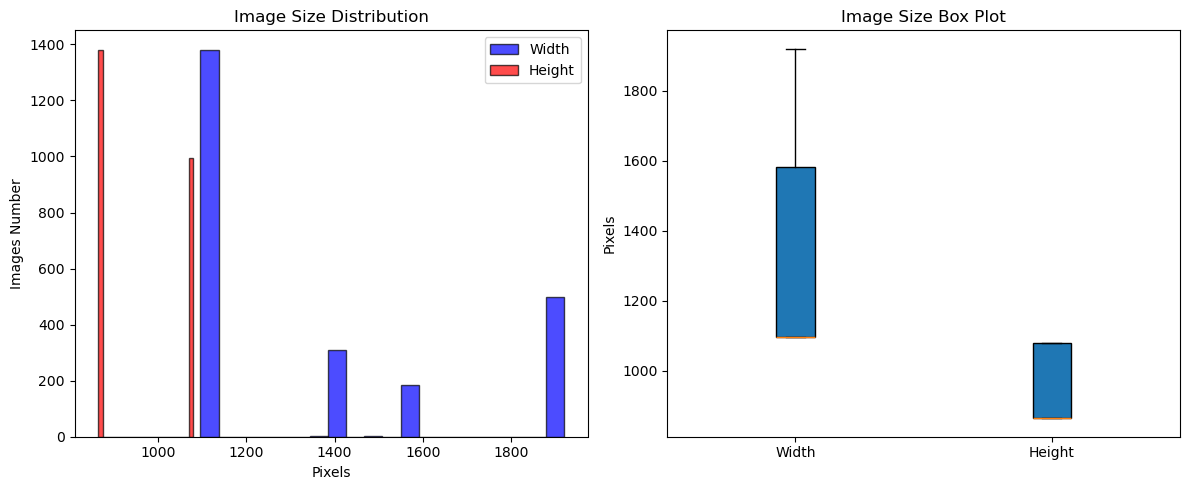

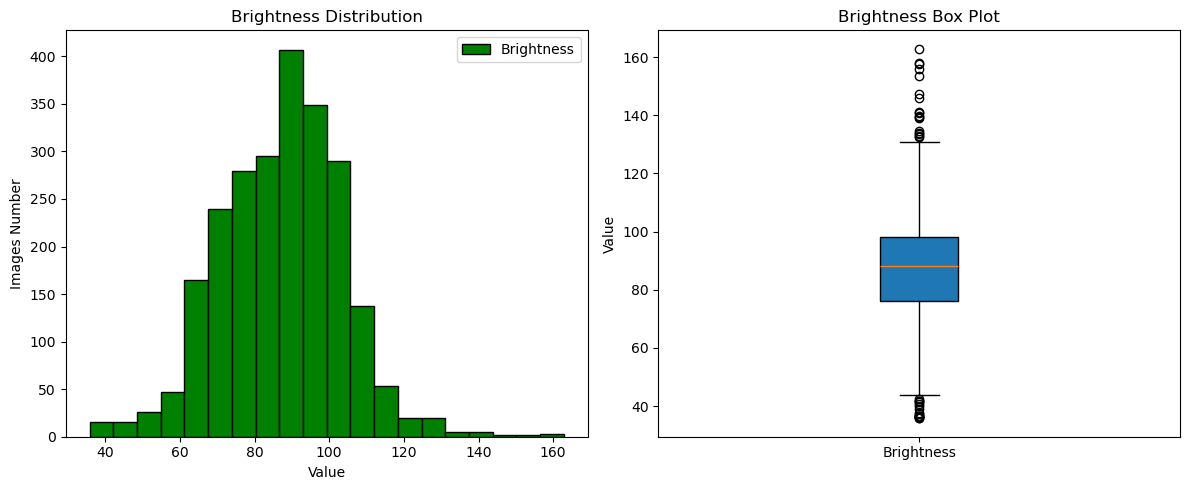

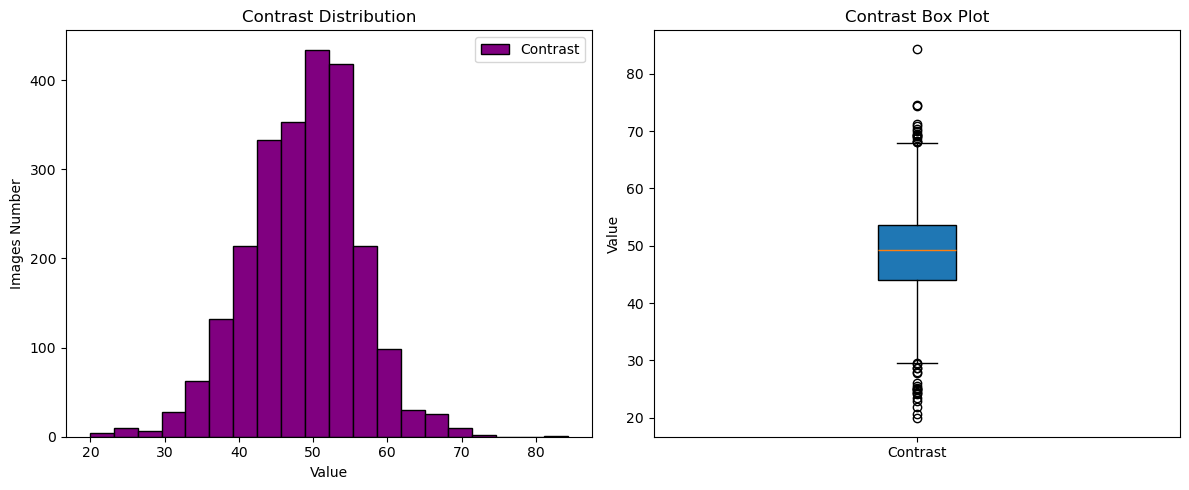

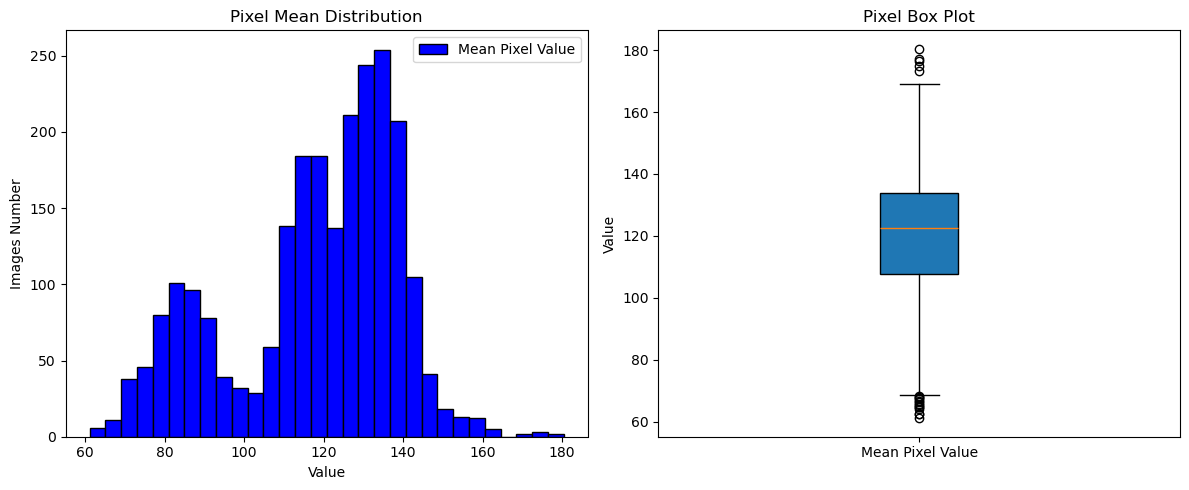

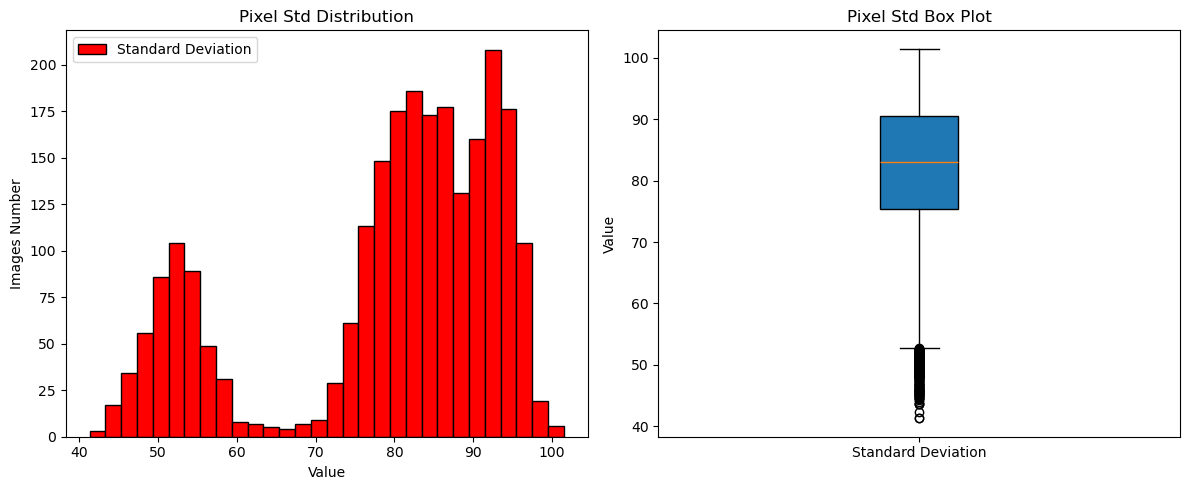

In [31]:
# Overall statistics plot
plot_image_statistics(train_stats)

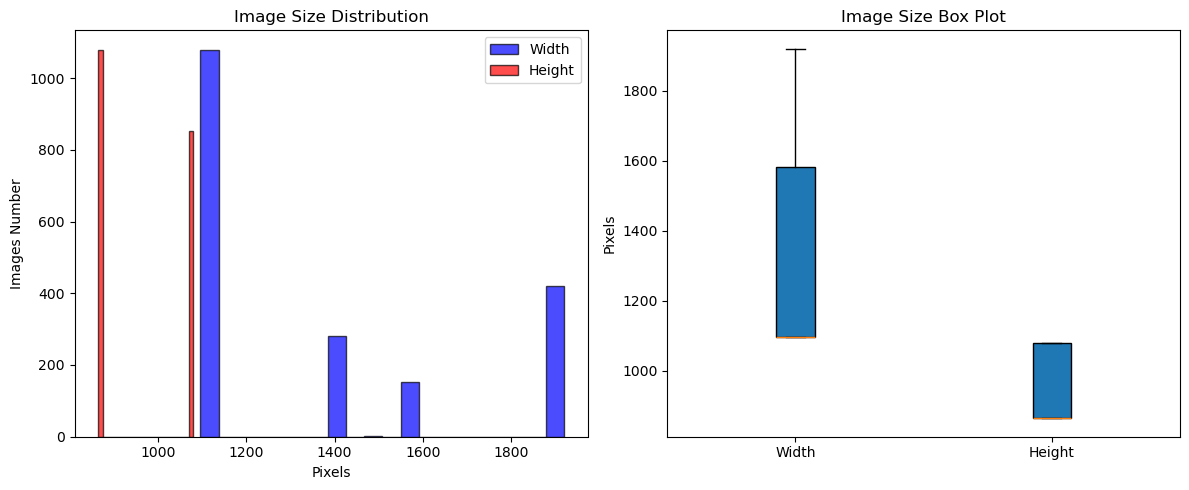

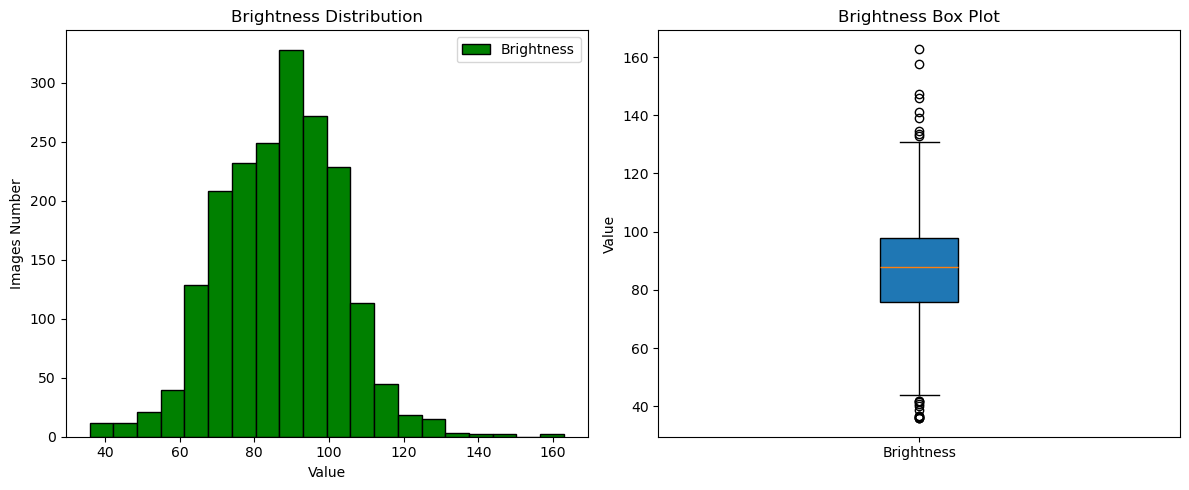

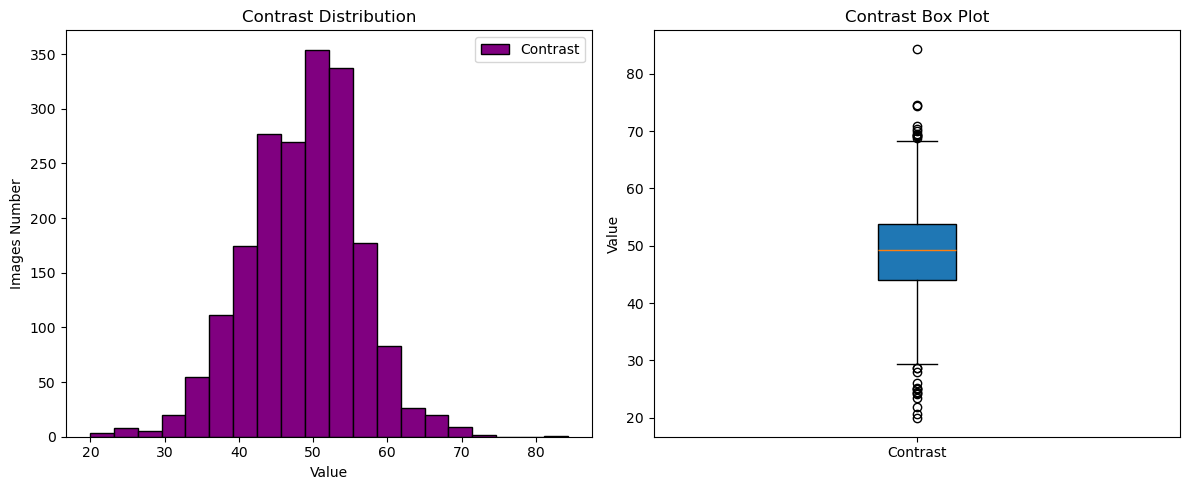

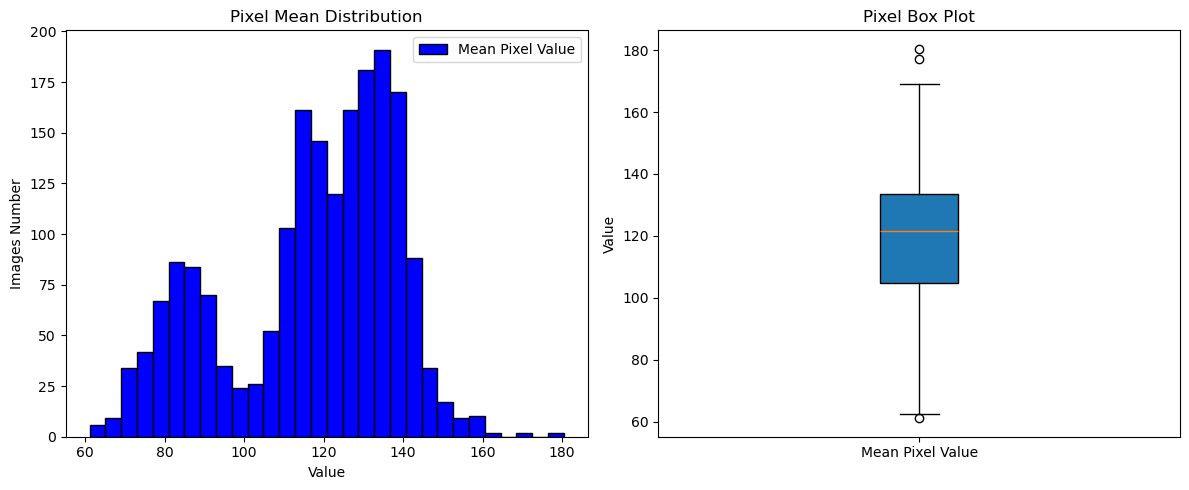

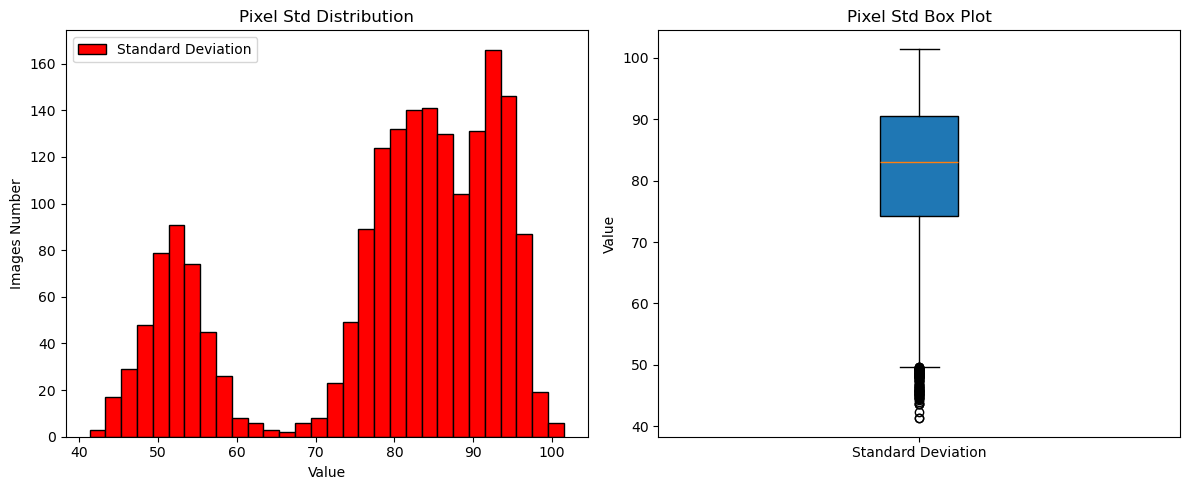

In [39]:
# Adenoma statistics plot
plot_image_statistics(train_adenoma_stats)

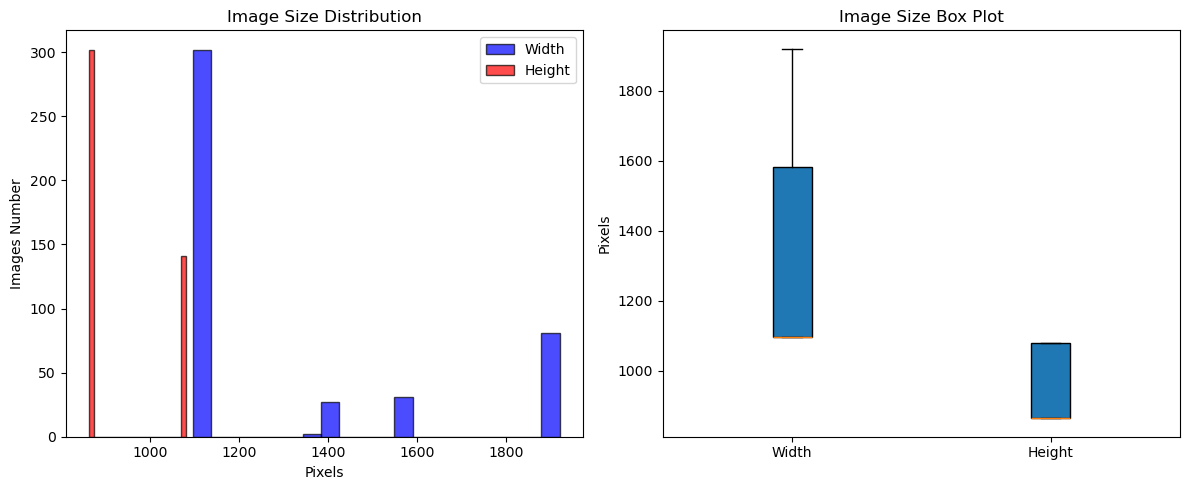

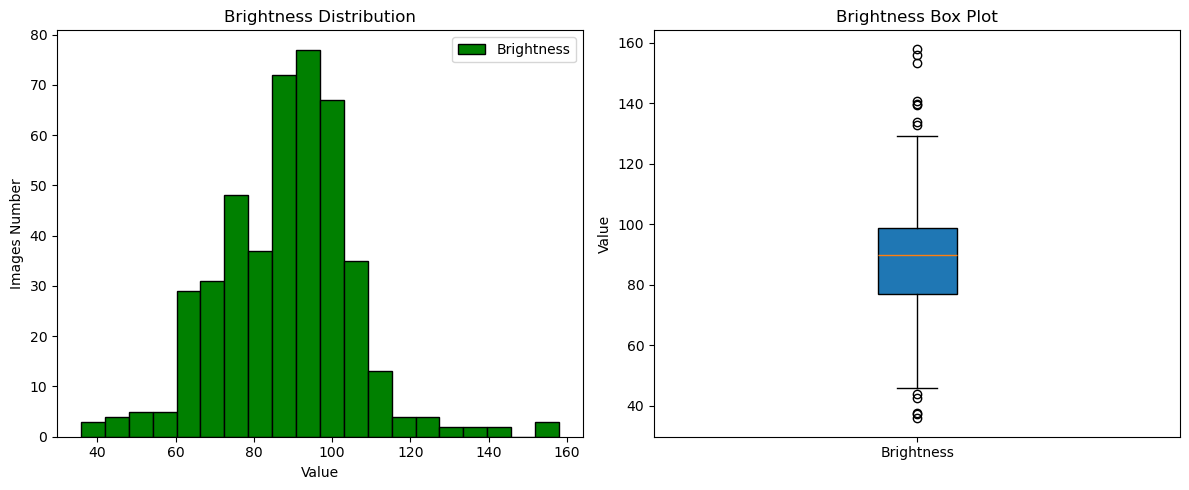

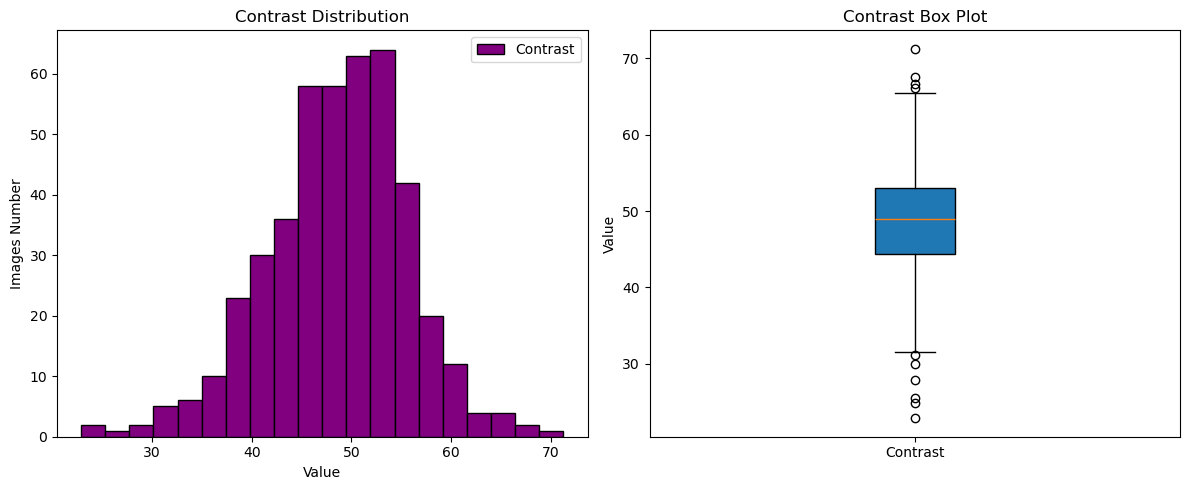

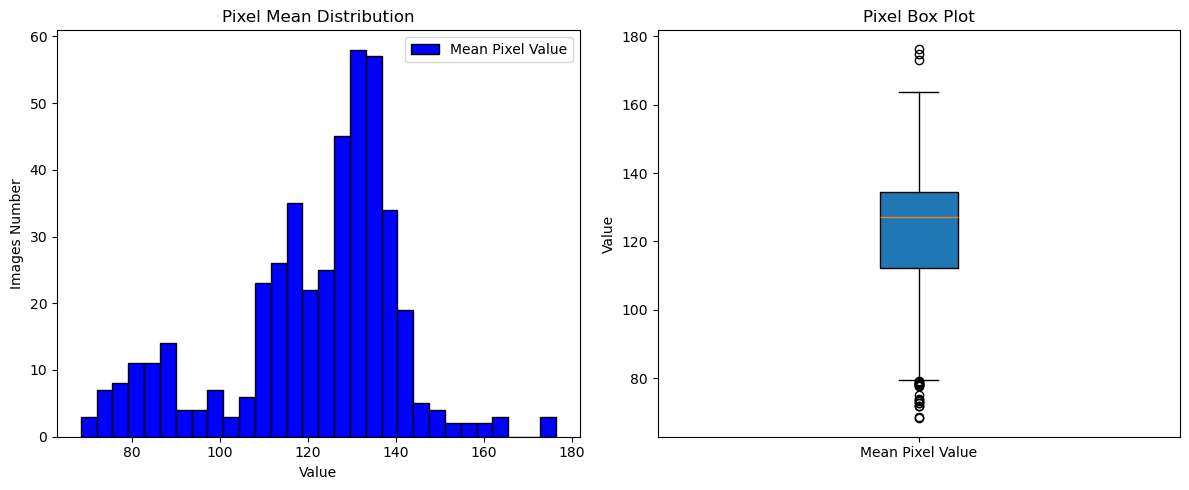

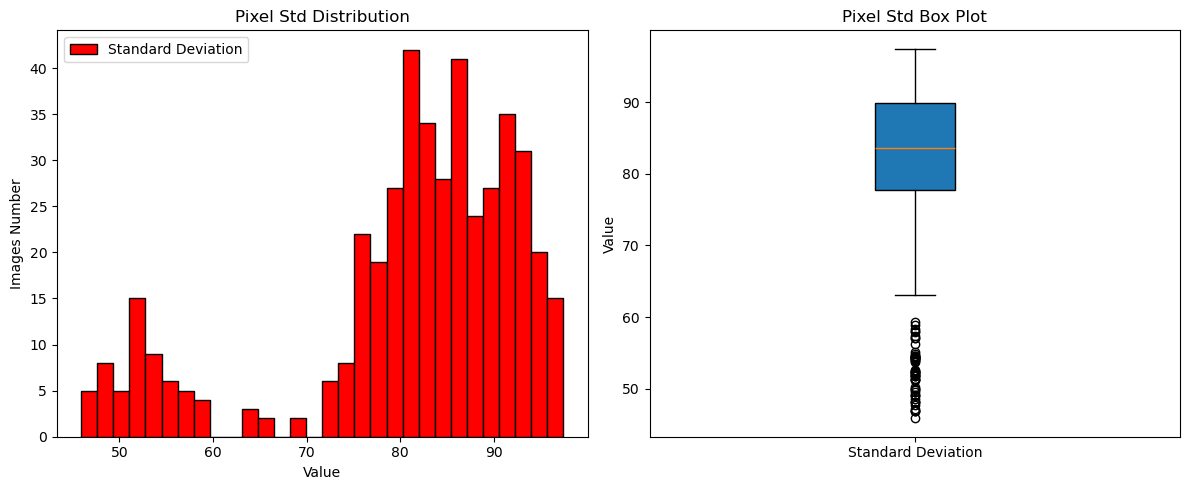

In [40]:
# Hyperplastic statistics plot
plot_image_statistics(train_hyper_stats)

In [ ]:
# Train set Preprocessing

In [ ]:
# Train set data augmentation
